In [1]:
import pandas as pd
import numpy as np
from random import sample
from sklearn import linear_model as sklm
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
%pylab inline



Bad key "back end" on line 1 in
/Users/bethevans/.matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


Populating the interactive namespace from numpy and matplotlib


/Users/bethevans/.virtualenvs/zoopy/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['sample']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
def separate_dates(dataframe, col1, col2):
    strain_1_labels = list(dataframe[col1])
    strain_2_labels = list(dataframe[col2])
    
    strain_1_dates = []
    strain_2_dates = []
    
    for label in strain_1_labels:
        date = int(list(label.split('/'))[-1])
        if date <60:
            date+=2000
        else:
            date+=1900
        strain_1_dates.append(date)
        
    for label2 in strain_2_labels:
        date = int(list(label2.split('/'))[-1])
        if date <60:
            date+=2000
        else:
            date+=1900
        strain_2_dates.append(date)
    
    dataframe['strain_1_dates'] = pd.Series(strain_1_dates, index=dataframe.index)
    dataframe['strain_2_dates'] = pd.Series(strain_2_dates, index=dataframe.index)

In [3]:
def print_full(x):
    pd.set_option('display.max_columns', len(x))
    print(x)
    pd.reset_option('display.max_columns')

In [4]:
file = open('data.csv')
df = pd.read_csv(file)
df = df.drop(0)
separate_dates(df, 'AG1', 'AG2')

In [5]:
#print_full(df)

In [6]:
def random_sample(dataframe):
    global dftest, Xtrain, Xtest, ytrain, ytest, Xtrain_noham, Xtrain_ham, Xtest_noham, Xtest_ham
    
    dftrain, dftest = train_test_split(dataframe, test_size = 0.2)
    Xtrain = dftrain.drop(['AG1', 'AG2', 'strain_1_dates', 'strain_2_dates'], axis = 1)
    Xtest = dftest.drop(['AG1', 'AG2', 'strain_1_dates', 'strain_2_dates'], axis = 1)
    
    #remove rows with unseen substitutions
    unseen = []
    for column in Xtrain.columns:
        if sum(Xtrain[column]) == 0:
            unseen.append(column)
    print unseen
    for item in unseen:
        Xtrain = Xtrain[Xtrain[item] != 1]
        Xtest = Xtest[Xtest[item] != 1]
    
    #create X and y training and test data - for both
    ytrain = Xtrain['AG-DIST']
    ytest = Xtest['AG-DIST']
    Xtrain = Xtrain.drop(['AG-DIST'], axis = 1)
    Xtest = Xtest.drop(['AG-DIST'], axis = 1)
    
    #create X training and test data - remove hamming distance
    Xtrain_noham = Xtrain.drop(['NUM-MUTATIONS'], axis = 1)
    Xtrain_ham = Xtrain['NUM-MUTATIONS']
    Xtest_noham = Xtest.drop(['NUM-MUTATIONS'], axis = 1)
    Xtest_ham = Xtest['NUM-MUTATIONS']

In [7]:
random_sample(df)

['DR135']


In [8]:
#run with both hamming distance and amino acid substitutions

both = sklm.LinearRegression()
both.fit(Xtrain, ytrain)
score = both.score(Xtest, ytest)
print(score)

0.739774853544


/Users/bethevans/.virtualenvs/zoopy/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [9]:
#other bits of code you might want to use to check stuff

Xtrain_ham = Xtrain_ham.reshape(-1,1)
Xtest_ham = Xtest_ham.reshape(-1,1)
ytrain = ytrain.reshape(-1, 1)
ytest = ytest.reshape(-1, 1)
#print Xtrain_ham.shape
#print ytrain.shape
#print Xtest_ham.shape
#print ytest.shape

In [10]:
#run with hamming distance only
ham = sklm.LinearRegression()
ham.fit(Xtrain_ham, ytrain)
score = ham.score(Xtest_ham, ytest)
print(score)

0.198413955334


In [11]:
#run with amino acid substitutions only
aasub = sklm.LinearRegression()
aasub.fit(Xtrain_noham, ytrain)
score = aasub.score(Xtest_noham, ytest)
print(score)

0.739467593029


In [12]:
#other beth's error plot

def errorplot(clf, xtst):
    fig_size = [15, 6]
    plt.rcParams["figure.figsize"] = fig_size
    
    #Make a dataframe 'errors' to hold the ytest, predicted values, and errors, then sort by the error size
    errors = pd.DataFrame(data=ytest, columns =('AG-DIST',))
    errors['predicted'] = clf.predict(xtst)
    errors['error'] = errors['predicted'] - errors['AG-DIST']
    errors['date'] = dftest['strain_2_dates']
    errors = errors.sort_values('error')

    plt.figure(3)
    errors = errors.sort_values('date')
    
    #Add some random noise to the dates to avoid overplotting
    errors['jittered_dates'] = errors['date'] + np.random.uniform(-2, 2, len(ytest))
    
    plt.scatter(errors['jittered_dates'], errors['AG-DIST'], color = 'g', s=3, marker='o')
    plt.scatter(errors['jittered_dates'], errors['predicted'], color = 'b', s=3)
    plt.scatter(errors['jittered_dates'], errors['error'], color = 'r', s=3)
    plt.xlabel('Strain 2 dates')
    plt.ylabel('Antigenic distance')
    red_patch = mpatches.Patch(color='red', label='Error')
    green_patch = mpatches.Patch(color='green', label='True value')
    blue_patch = mpatches.Patch(color='blue', label='Predicted value')
    plt.legend(handles=[red_patch, green_patch, blue_patch])
    
    plt.figure(4)
    plt.hist(errors['error'], bins=30)
    plt.xlabel('error size')
    plt.ylabel('frequency')
    #plt.axvline(x=mean(errors['error']), color='r')

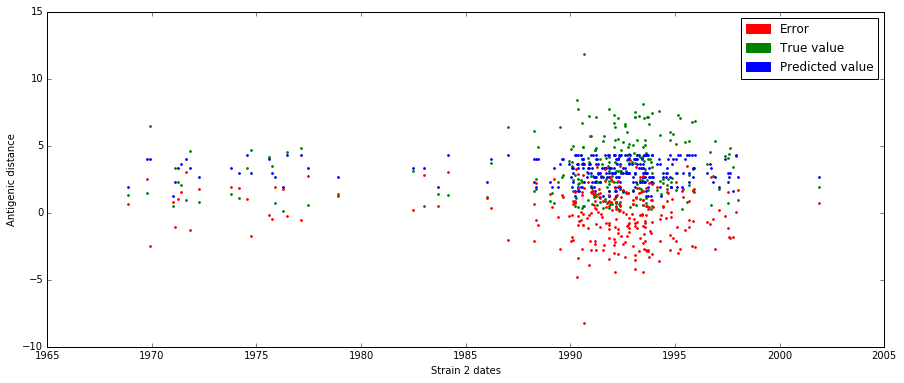

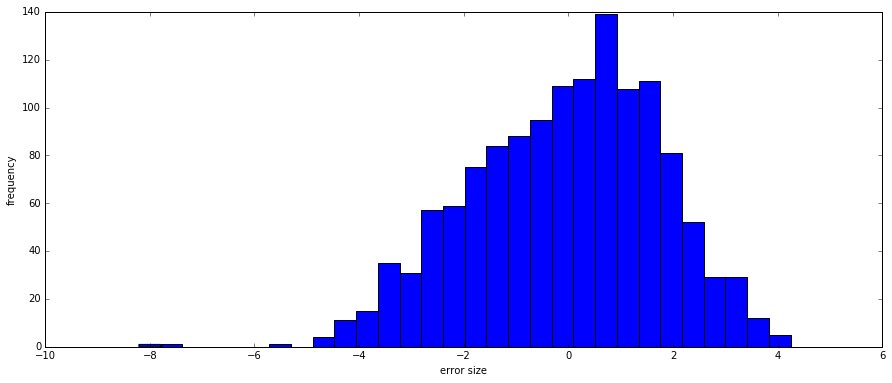

In [13]:
errorplot(ham, Xtest_ham)

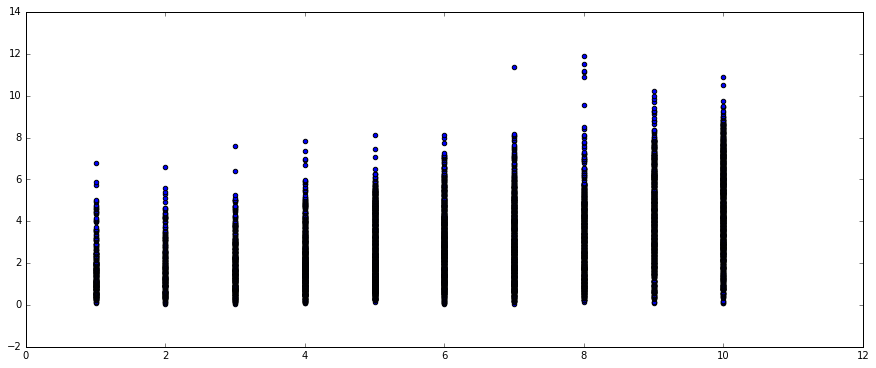

In [14]:
plt.scatter(df['NUM-MUTATIONS'], df['AG-DIST'])

(0, 17)

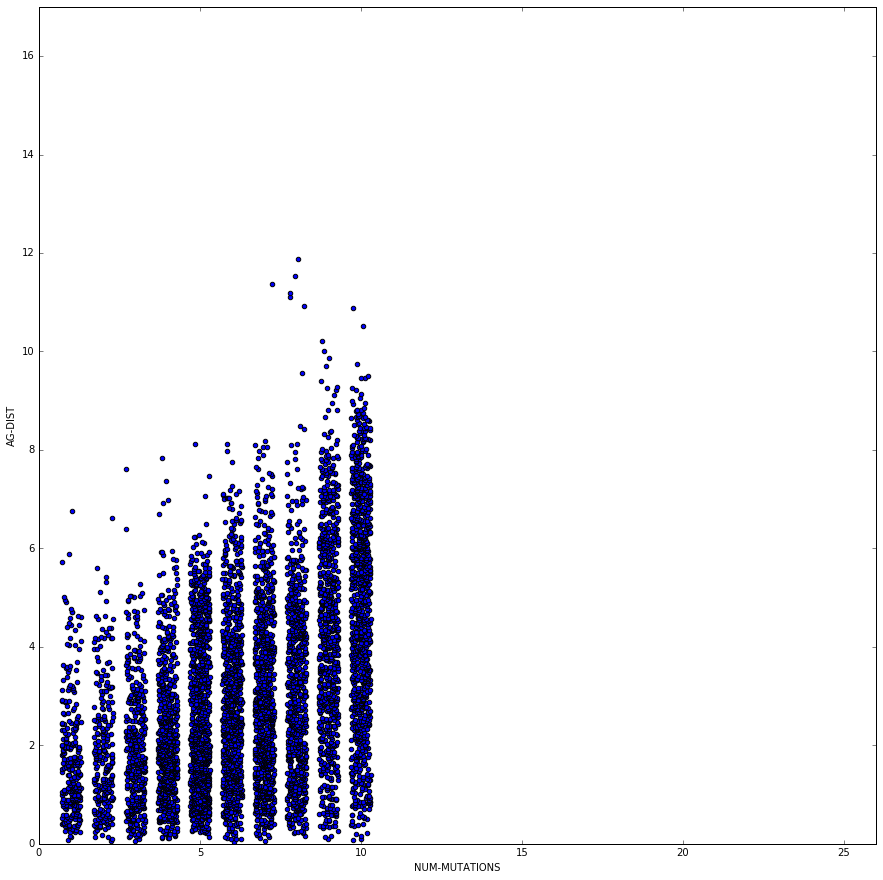

In [15]:
fig_size = [15, 15]
plt.rcParams["figure.figsize"] = fig_size
jitteredHD = df['NUM-MUTATIONS'] + np.random.uniform(-0.3, 0.3, len(df))
plt.xlabel('NUM-MUTATIONS')
plt.ylabel('AG-DIST')
plt.scatter(jitteredHD, df['AG-DIST'])
plt.xlim(0,26)
plt.ylim(0,17)